In [ ]:
# get necessary imports
from soslib import funcs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import act
import nctoolkit as nc
from metpy.units import units
import pytz

Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo
Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


In [ ]:
# functions I will need 
def apogee2temp(dat,tower):
# hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = dat[f"IDir_{tower}"]
    sns = [136, 137, 138, 139]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
# unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234][im]* 1e5
# read data
    Vtherm = dat[f"Vtherm_{tower}"]
    Vpile = dat[f"Vpile_{tower}"]*1000
# calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
# finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    TTc = TTc
    return TTc

def addlocaltime(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    ds.coords.update({'local_time':tz_corrected})
    return ds

In [ ]:
SIGMA = 5.67e-8 # Stephan-Boltzmann constant

# information that is needed to use functions
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
# products
sebs = 'gucsebsM1.b1'
surf = 'gucgndirtM1.b1'
# start and end
start = '2023-01-20'
end = '2023-01-21'


# grab SAIL surface data
ds_surface = funcs.get_sail_data(username, token, surf, start, end)
# grab SAIL surface energy balance data
ds_sebs = funcs.get_sail_data(username, token, sebs, start, end)
# grab SPLASH Radsys data
ds_radsys = funcs.get_daily_radsys_data(start,end)


[DOWNLOADING] gucgndirtM1.b1.20230120.000000.nc
                             
[DOWNLOADING] gucsebsM1.b1.20230120.000000.cdf
                             
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23020.dat


HTTPError: HTTP Error 404: Not Found

In [ ]:
# grab SOS surface temperature data
dates = np.arange(20230122,20230124,1)
dss = []
for date in dates:
    dss.append(nc.open_url(f'ftp://ftp.eol.ucar.edu/pub/archive/isfs/projects/SOS/netcdf/noqc_geo/isfs_{date}.nc').to_xarray()[['Rpile_out_9m_d',
                                                                                                                                'Tcase_out_9m_d', 
                                                                                                                                'Vpile_d', 
                                                                                                                                'Vtherm_d', 
                                                                                                                                'IDir_d',
                                                                                                                                'Vpile_c',
                                                                                                                                'Vtherm_c', 
                                                                                                                                'IDir_c',
                                                                                                                                'Vpile_uw',
                                                                                                                                'Vtherm_uw', 
                                                                                                                                'IDir_uw',
                                                                                                                                'Vpile_ue',
                                                                                                                                'Vtherm_ue', 
                                                                                                                                'IDir_ue',
                                                                                                                                'Tsnow_0_4m_d',
                                                                                                                                'Tsnow_0_5m_d',
                                                                                                                                'Tsnow_0_6m_d']])

In [1]:
ds_sos = xr.concat(dss, dim='time')

NameError: name 'xr' is not defined

In [ ]:
SIGMA = 5.67e-8 # Stephan-Boltzmann constant

ds_sos= ds_sos.assign(TsurfLW = ((ds_sos.Rpile_out_9m_d + (ds_sos.Tcase_out_9m_d+273.15)**4*SIGMA)/SIGMA/0.98)**0.25 - 273.15)
ds_sos = ds_sos.assign(Tsurfapogee_d=apogee2temp(ds_sos,'d'))
ds_sos = ds_sos.assign(Tsurfapogee_c=apogee2temp(ds_sos,'c'))
ds_sos = ds_sos.assign(Tsurfapogee_uw=apogee2temp(ds_sos,'uw'))
ds_sos = ds_sos.assign(Tsurfapogee_ue=apogee2temp(ds_sos,'ue'))

In [ ]:
ds_sos = addlocaltime(ds_sos)

In [ ]:
ds_sebs['Tsurf'] = ((ds_sebs['up_long']/SIGMA/0.98)**0.25 - 273.15).resample(time='30min').mean()
ds_radsys['Tsurf'] = ((ds_radsys['uw_ir']/SIGMA/0.98)**0.25 - 273.15).resample(time='30min').mean()

NameError: name 'ds_sebs' is not defined

In [ ]:
import datetime as dt

In [ ]:
central_apogee_temp = -7.7
central_apogee_time = dt.datetime(2023,1,21,12,37)

uw_apogee_temp = -8.7
uw_apogee_time = dt.datetime(2023,1,21,12,41)

Text(0.5, 0, 'Time (Local)')

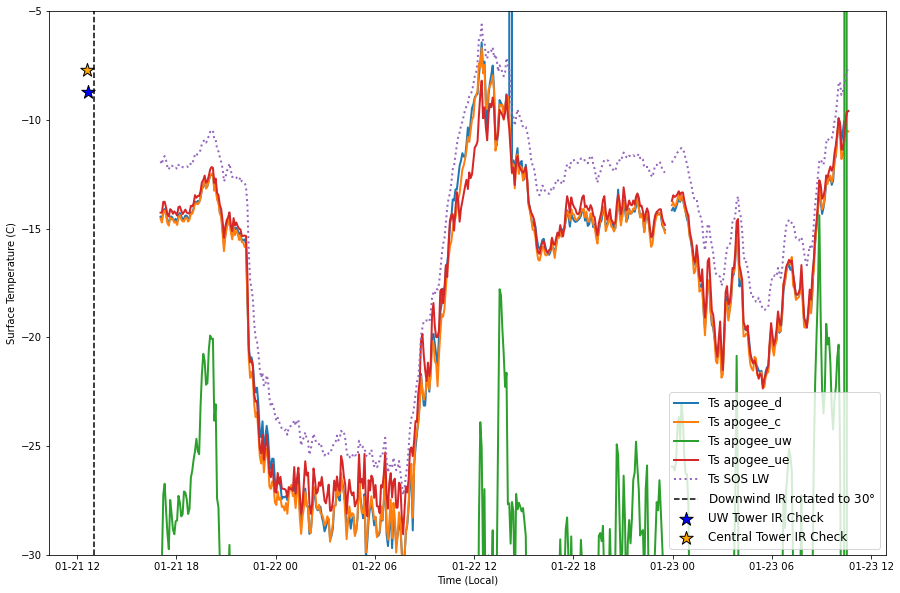

In [ ]:

plt.figure(figsize=(15,10))

plt.plot(ds_sos['local_time'],ds_sos['Tsurfapogee_d'],label='Ts apogee_d', lw=2)
plt.plot(ds_sos['local_time'],ds_sos['Tsurfapogee_c'],label='Ts apogee_c', lw=2)
plt.plot(ds_sos['local_time'],ds_sos['Tsurfapogee_uw'],label='Ts apogee_uw', lw=2)
plt.plot(ds_sos['local_time'],ds_sos['Tsurfapogee_ue'],label='Ts apogee_ue', lw=2)
# (ds_sebs['Tsurf']).plot(label='Ts SAIL LW', lw=2 ,ls='dotted')
plt.plot(ds_sos['local_time'],ds_sos['TsurfLW'],label='Ts SOS LW', lw=2, ls='dotted')
plt.scatter(uw_apogee_time,uw_apogee_temp, marker='*', s=200,color='blue', label='UW Tower IR Check', ec='k')
plt.scatter(central_apogee_time,central_apogee_temp, marker='*', s=200,color='orange', label='Central Tower IR Check', ec='k')
plt.axvline(dt.datetime(2023,1,21,13,1), ls='--', color='k', label='Downwind IR rotated to 30$\degree$')
# ds_radsys['Tsurf'].plot(label='Ts SPLASH LW', lw=2,ls='dotted')
# (ds_surface['sfc_ir_temp']-273.15).plot(label='Ts SAIL IR Temp', lw=2, ls='--')
plt.legend(fontsize=12)
# plt.xlim(dt.datetime(2023,1,21,12), dt.datetime(2023,1,21,14))
plt.ylim(-30,-5)
plt.ylabel('Surface Temperature (C)')
plt.xlabel('Time (Local)')

NameError: name 'ds_sebs' is not defined

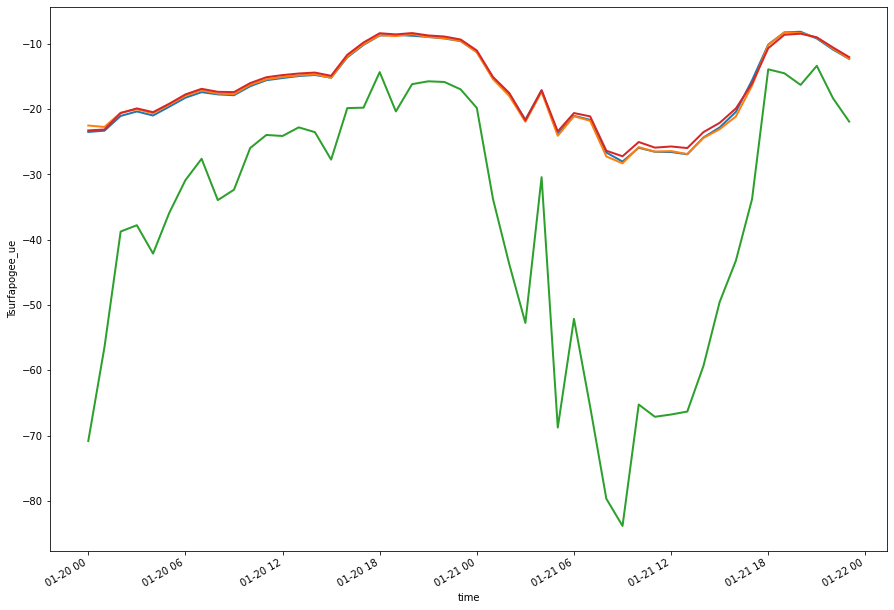

In [54]:
plt.figure(figsize=(15,10))

(ds_sos['Tsurfapogee_d']).resample(time='1H').mean().plot(label='Ts apogee_d', lw=2)
(ds_sos['Tsurfapogee_c']).resample(time='1H').mean().plot(label='Ts apogee_c', lw=2)
(ds_sos['Tsurfapogee_uw']).resample(time='1H').mean().plot(label='Ts apogee_uw', lw=2)
(ds_sos['Tsurfapogee_ue']).resample(time='1H').mean().plot(label='Ts apogee_ue', lw=2)
(ds_sebs['Tsurf']).resample(time='1H').mean().plot(label='Ts SAIL SEBS', lw=2 ,ls='dotted')
(ds_sos['TsurfLW']).resample(time='1H').mean().plot(label='Ts sos lw', lw=2, ls='dotted')
ds_radsys['Tsurf'].plot(label='Ts SPLASH lw', lw=2,ls='dotted')
((ds_surface['sfc_ir_temp']-273.15)).resample(time='1H').mean().plot(label='Ts SAIL ir', lw=2, ls='--')
plt.legend(fontsize=12)

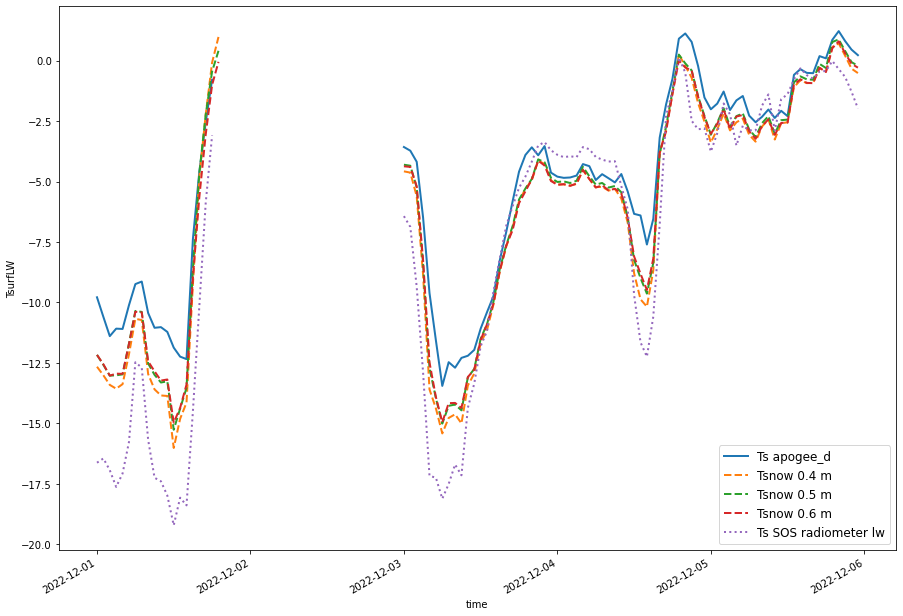

In [72]:
plt.figure(figsize=(15,10))

(ds_sos['Tsurfapogee_d']).resample(time='1H').mean().plot(label='Ts apogee_d', lw=2)
ds_sos['Tsnow_0_4m_d'].resample(time='1H').mean().plot(label='Tsnow 0.4 m', lw=2, ls='--')
ds_sos['Tsnow_0_5m_d'].resample(time='1H').mean().plot(label='Tsnow 0.5 m', lw=2, ls='--')
ds_sos['Tsnow_0_6m_d'].resample(time='1H').mean().plot(label='Tsnow 0.6 m', lw=2, ls='--')
(ds_sos['TsurfLW']).resample(time='1H').mean().plot(label='Ts SOS radiometer lw', lw=2, ls='dotted')
plt.legend(fontsize=12)